# Generate Topic Data

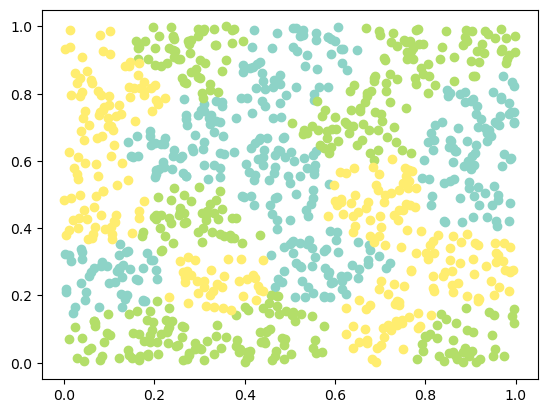

In [1]:
import sys
import os
import numpy as np
from numpy.linalg import norm, svd, solve, qr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
import networkx as nx

import scipy
from scipy.sparse import csr_matrix
from scipy.optimize import linear_sum_assignment

import cvxpy as cp
from cvxpy import Variable
from cvxpy.problems.objective import Minimize
from cvxpy.problems.problem import Problem

sys.path.append('./SpLSI/pycvxcluster/src/')
import pycvxcluster.pycvxclt

from SpLSI import generate_topic_model as gen_model
from SpLSI.utils import *
from SpLSI.spatialSVD import *
#from netgraph import Graph
#from netgraph import get_sugiyama_layout

N = 100 # doc length
n = 1000 # number of nodes
p = 30 # vocab size
K = 3 # number of topics
r = 0.05 # heterogeneity parameter
m = 5 # number of neighbors to be considered in weights
phi = 0.5 # weight parameter

df, W, A, D = gen_model.generate_data(N, n, p , K, r)
gen_model.plot_scatter(df)

# MST Folds / Matrix Denoising via Iterative Convex Clustering

In [2]:
weights = gen_model.generate_weights(df, K, m, phi)
G, mst, path = generate_mst(df, weights, n)
srn, fold1, fold2 = get_folds(mst, path, n, plot_tree=False)
folds = {0:fold1, 1:fold2}

Source node is 201


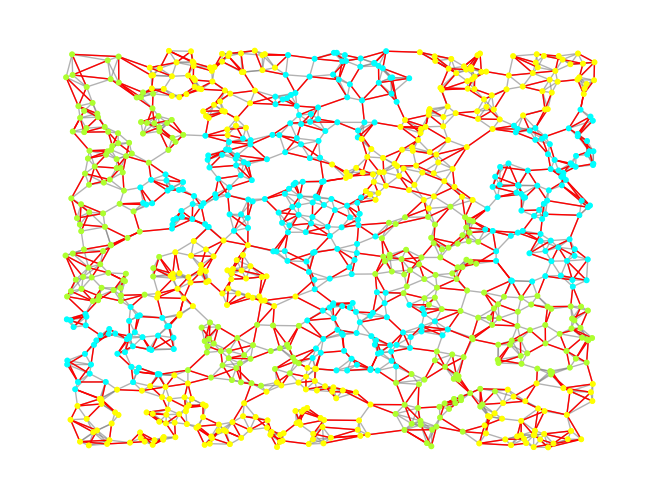

In [3]:
colors = gen_model.get_colors(df)
# Plot the random graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=10, node_color=colors, edge_color='gray', alpha=0.6)

# Plot the minimum spanning tree in red
nx.draw(mst, pos, with_labels=False, node_size=10, node_color=colors, edge_color='r', alpha=1)

plt.show()

# Spatial pLSI

In [4]:
#U, L, V = trunc_svd(X, K)
#lambds = (0.3*np.power(2, np.arange(5))).tolist()
#U, lambd = run_iter_cvx(X, L, V, weights, folds, lambds, n, K, eps=1e-03)

#### Test SpatialSVD

In [4]:
X = D.T
U, L, V = trunc_svd(X, K)
lambds = (0.3*np.power(2, np.arange(5))).tolist()
lambds

[0.3, 0.6, 1.2, 2.4, 4.8]

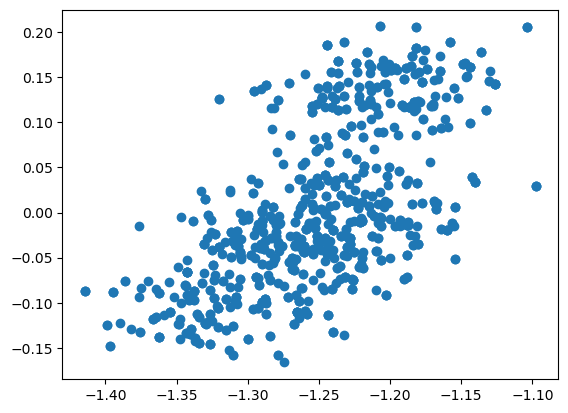

In [23]:
plt.scatter(XVL[:,0],XVL[:,1])

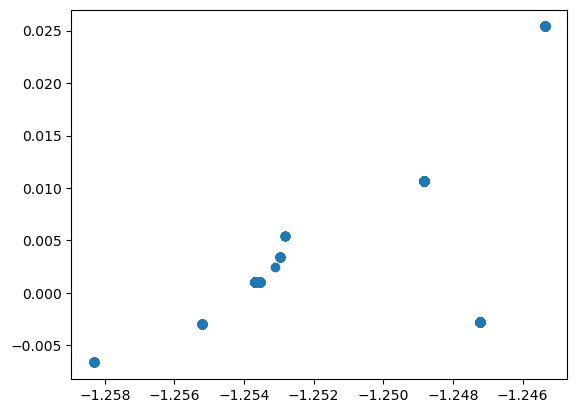

In [26]:
j = 1
fold = folds[j]
X_tilde = interpolate_X(X, folds, j, path, mst, srn)
X_j = X_tilde[fold,:]
XVL = np.dot(np.dot(X_tilde, V), inverse_L(L))

lambd = 1
ssnal = pycvxcluster.pycvxclt.SSNAL(gamma=lambd, verbose=0)
ssnal.fit(X=XVL, weight_matrix=0.8*weights, save_centers=True)
U_hat = ssnal.centers_.T

plt.scatter(U_hat[:,0],U_hat[:,1])

In [ ]:
U, lambd, errors = update_U_tilde(X, L, V, weights, folds, path, mst, srn, lambds, n, K)